<h1><center> MATH 472/572 Computational Statistics - Spring 2020 </h1></center>
<h2><center> Homework 5 - February 25, Thursday </h2></center>
<h3><center> Instructor: Leming Qu </h3></center>

<h1><center> Student: Arash Modaresi Rad </h1></center>

## Coding Assignments:

1. Problem 2.6 on page 56 of the Computation Statistics book.
Required output to be embedded within the submitted Jupyter Notebook:
All the output corresponding to a specific question must begin in a Markdown Cell with a
heading, for example,

(a) Present your estimates in the last 5 iterations in a format similar to Table 2.1. Plot the
fitted model together with the observed data in a single plot.

In [1]:
import time
import numpy as np
import seaborn as sb
import sympy as sym
from sympy import *
from numpy import ma
from numpy.linalg import inv
from numpy import linalg as LA
import pandas as pd 
import matplotlib.pyplot as plt  
import functools as fts
from tabulate import tabulate as tabulate
import pymc3
from scipy.stats import norm
from scipy.optimize import fmin
from scipy.stats import *
from matplotlib.patches import Polygon
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy import Function
import sympy as sym
np.random.seed(1000)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\Uchiha_Arash\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Answer to part (a):

a. Fit the logistic growth model to the flour beetle data using the Gauss–Newton
approach to minimize the sum of squared errors between model predictions and
observed counts

load the dataset:

In [2]:
Dataset = pd.DataFrame({'Days':[0,8,28,41,63,79,97,117,135,154],
                        'Beetles':[2,47,192,256,768,896,1120,896,1184,1024]})
Dataset.head()

,Days,Beetles
0,0,2
1,8,47
2,28,192
3,41,256
4,63,768


In [3]:
class Functions:
    """This function returns function values as well as their derivatives"""
    
    def __init__(self):
        self.func_value = 0
        self.dfunc_value = 0
        self.dfunc_k_value = 0
        self.dfunc_r_value = 0
        self.ddfunc_k_value = 0
        
    def F(self, t):
        Ftot = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0, len(t)):
            Ftot[i] = (K * N0)/(N0 + (K - N0) * sym.exp(-r * t[i]))
        return Ftot


    def dF(self, t):
        dFtot = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            dFtot[i] = (K * N0 * (K - N0) * r * sym.exp(-r * t[i]))/(N0 + (K - N0) * sym.exp(-r * t[i])) ** 2
        return dFtot


    def dF_k(self, t):
        dFtot_k = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            dFtot_k[i] = ((-K * N0 * sym.exp(-r * t[i])) / ((N0 + (K - N0) * sym.exp(-r * t[i])) ** 2)) + (N0 / (N0 + (K - N0) * sym.exp(-r * t[i])))
        return dFtot_k
    
    def ddF_k(self, t):
        ddFtot_k = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            ddFtot_k[i] = (K * N0 * 2 * sym.exp(-2 * r * t[i])) / ((N0 + (K - N0) * sym.exp(-r * t[i])) ** 3) - (2 * N0 * sym.exp(-r * t[i])) / ((N0 + (K - N0) * sym.exp(-r * t[i]))) ** 2
        return ddFtot_k


    def dF_r(self, t):
        dFtot_r = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            dFtot_r[i] = (K * N0 * t[i] * (K - N0) * sym.exp(-r * t[i])) / ((N0 + (K - N0) * sym.exp(-r * t[i])) ** 2)
        return dFtot_r

    def Main(self, Data):
        func_eval = self.F(Data)
        self.func_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], func_eval, 'numpy')
        dfunc_eval = self.dF(Data)
        self.dfunc_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], dfunc_eval, 'numpy') 
        dfunc_k_eval = self.dF_k(Data)
        self.dfunc_k_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], dfunc_k_eval, 'numpy') 
        dfunc_r_eval = self.dF_r(Data)
        self.dfunc_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], dfunc_r_eval, 'numpy') 
        ddfunc_k_eval = self.ddF_k(Data)
        self.ddfunc_k_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], ddfunc_k_eval, 'numpy') 
        return {'F':self.func_value, 'dF':self.dfunc_value, 'dF_K':self.dfunc_k_value, 'dF_r':self.dfunc_r_value, 'ddF_K':self.ddfunc_k_value}
    
    def __repr__(self):
        return "Functions func_value:% s dfunc_value:% s dfunc_k_value:% s dfunc_r_value:% s ddfunc_k_value:% s" % (self.func_value, self.dfunc_value, self.dfunc_k_value, self.dfunc_r_value, self.ddfunc_k_value)  


In [4]:
def GN(x,Start1,Start2,maxitt):
    itt = 0
    i = 0
    eps = 0.001
    K = Start1
    r = Start2
    res = np.sum((x - Functions().Main(Dataset['Days'])['F'](K, r)) ** 2)
    GN_Result = pd.DataFrame(columns = ['K', 'r', 'Residuals'])
    GN_Result.loc[0] = [K, r, res]
 
    j=1
    
    for i in range(10000):
        diff = x - Functions().Main(Dataset['Days'])['F'](K, r)
        primes = np.column_stack((Functions().Main(Dataset['Days'])['dF_K'](K, r), Functions().Main(Dataset['Days'])['dF_r'](K, r)))        
        [[K], [r]] = [[K], [r]] + inv(primes.T.dot(primes)).dot(primes.T).dot(diff)
        res = np.sum((x - Functions().Main(Dataset['Days'])['F'](K, r)) ** 2)
        GN_Result.loc[i] = [K, r, res]
        std_error_r = np.sqrt(inv(primes.T.dot(primes)).diagonal())[0] * np.sqrt(res / (len(x) - 2))
        std_error_K = np.sqrt(inv(primes.T.dot(primes)).diagonal())[1] * np.sqrt(res / (len(x) - 2))
        correlation =  inv(primes.T.dot(primes))[0][1] / (np.sqrt(inv(primes.T.dot(primes)).diagonal())[0] * np.sqrt(inv(primes.T.dot(primes)).diagonal())[1])
        print(tabulate([[itt, K, r, res, std_error_r, std_error_K, correlation]], headers=['iteration', 'K', 'r','residual', 'std_error_r', 'std_error_K','correlation'], tablefmt='orgtbl'))
        
        if res[0]<eps:
            print('Solution found based on starting value of ' + str(Start1) +  ' , ' + str(Start2) +  ' : ' + str(K)  +  ' , ' + str(r))
            print('Itteration: ' + str(itt))
            break
            
        elif itt == maxitt:
            print("The maximum number of itterations reached!") 
            print('Solution found based on starting value of ' + str(Start1) +  ' , ' + str(Start2) +  ' : ' + str(K) +  ' , ' + str(r))
            print('Itteration: ' + str(itt))
            break
        itt = itt + 1

    return GN_Result

In [5]:
GN_out = GN(Dataset[['Beetles']], 150, 0.5, 100)

|   iteration |       K |        r |    residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+-------------+---------------+---------------+---------------|
|           0 | 792.047 | 0.053754 | 2.56223e+06 |       200.094 |       1.93419 |    -0.0627529 |
|   iteration |       K |         r |    residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+-----------+-------------+---------------+---------------+---------------|
|           1 | 448.434 | 0.0972056 | 2.05026e+06 |       692.442 |     0.0208459 |     -0.738674 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|           2 | 1037.24 | 0.130201 |     101641 |       55.5969 |     0.0160917 |     -0.378452 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|----------

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          28 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          29 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          30 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          56 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          57 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          58 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          84 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          85 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          86 | 1033.52 | 0.117959 |    83240.5 |       47.8238 |    0.00777512 |     -0.342842 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

Plotting the fitting results:

Text(0, 0.5, 'Beetles')

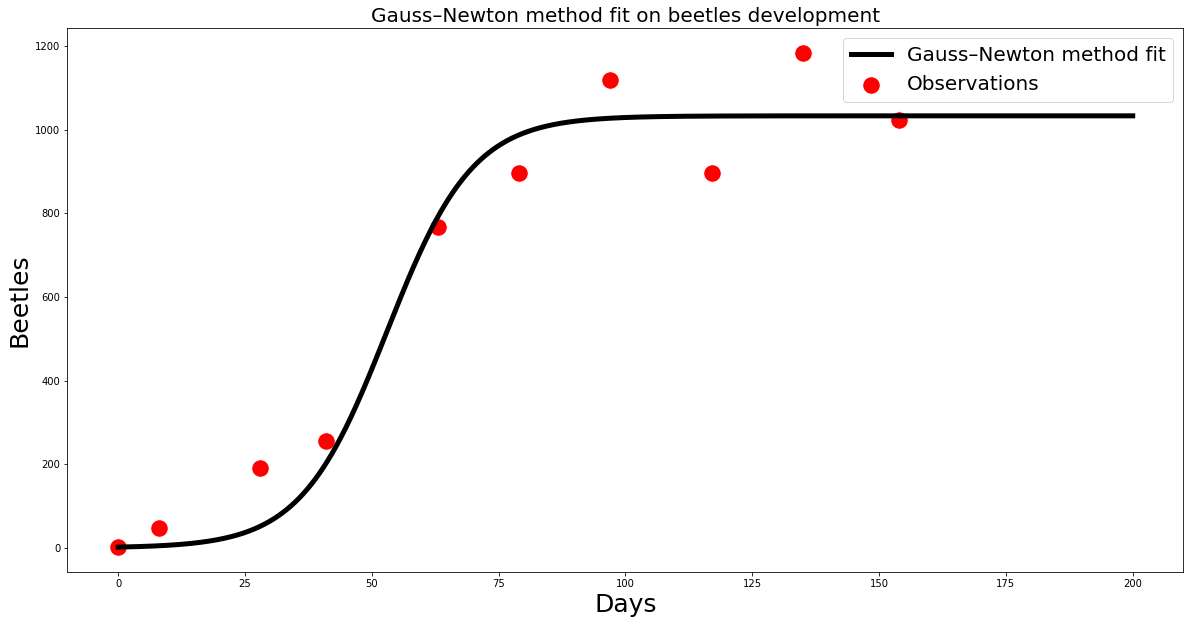

In [6]:
plt.figure(figsize = (20,10))
t_new = np.linspace(0,200,1000)
X_predict = Functions().Main(t_new)['F'](GN_out['K'].iloc[-1], GN_out['r'].iloc[-1])
sb.scatterplot(data=Dataset,x='Days',y='Beetles',color="red",alpha=1,s=300)
plt.title("Gauss–Newton method fit on beetles development",fontsize=20)
plt.plot(t_new, X_predict, 'k', linewidth= 5)
plt.legend(("Gauss–Newton method fit", "Observations"),fontsize=20)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Beetles',fontsize=25)

(b) Present your estimates in the last 5 iterations in a format similar to Table 2.1. Plot the
fitted model together with the observed data in a single plot.

### Answer to part (b):

b. Fit the logistic growth model to the flour beetle data using the Newton–Raphson
approach to minimize the sum of squared errors between model predictions and
observed counts.

In [7]:
class Seccond_derivatives:
    """This function returns seccond derivatives values"""
    
    def __init__(self):
        self.F =10
        self.dF_K = 0
        self.ddF_K = 0
        self.dF_r = 0
        self.ddF_r = 0
        self.ddF_K_r = 0
        self.F_value = 0
        self.dF_K_value = 0
        self.ddF_K_value = 0
        self.dF_r_value = 0
        self.ddF_r_value = 0
        self.ddF_K_r_value = 0
        self.G = 0
        self.dG_K = 0
        self.ddG_K = 0
        self.dG_r = 0
        self.ddG_r = 0
        self.ddG_K_r = 0
        
    def Func(self):
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        t = sym.Symbol('t')
        N0 = 2
        self.F = (K * N0)/(N0 + (K - N0) * sym.exp(-r * t))
        self.dF_K = self.F.diff(K)
        self.ddF_K = self.dF_K.diff(K)
        self.dF_r = self.F.diff(r)
        self.ddF_r = self.dF_r.diff(r)
        self.ddF_K_r = self.dF_K.diff(r)
        return {'F':self.F, 'dF_K':self.dF_K, 'ddF_K':self.ddF_K, 'dF_r':self.dF_r, 'ddF_r':self.ddF_r, 'ddF_K_r':self.ddF_K_r}
    
        
    def Apply(self):
        F_eval = self.Func()['F']
        self.F_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], F_eval, 'numpy')
        dF_K_eval = self.Func()['dF_K']
        self.dF_K_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], dF_K_eval, 'numpy')
        ddF_K_eval = self.Func()['ddF_K']
        self.ddF_K_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_K_eval, 'numpy')
        dF_r_eval = self.Func()['dF_r']
        self.dF_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], dF_r_eval, 'numpy')
        ddF_r_eval = self.Func()['ddF_r']
        self.ddF_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_r_eval, 'numpy')
        ddF_K_r_eval = self.Func()['ddF_K_r']
        self.ddF_K_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_K_r_eval, 'numpy')
        return {'F_value':self.F_value, 'dF_K_value':self.dF_K_value, 'ddF_K_value':self.ddF_K_value, 'dF_r_value':self.dF_r_value, 'ddF_r_value':self.ddF_r_value, 'ddF_K_r_value':self.ddF_K_r_value}

    
    def Gfunc(self,x, t, K, r):
        i = 0
        for i in range (0,len(t)):
            self.G += (x[i] - self.Apply()['F_value'](K,r,t[i])) ** 2
            self.dG_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['dF_r_value'](K,r,t[i])
            self.dG_K += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['dF_K_value'](K,r,t[i]) 
            self.ddG_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_r_value'](K,r,t[i]) + (2 * (self.Apply()['dF_r_value'](K,r,t[i]) ** 2))
            self.ddG_K += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_K_value'](K,r,t[i]) + (2 * (self.Apply()['dF_K_value'](K,r,t[i]) ** 2))
            self.ddG_K_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_K_r_value'](K,r,t[i]) + (2 * (self.Apply()['dF_K_value'](K,r,t[i]) * self.Apply()['dF_r_value'](K,r,t[i])))

        return {'G':self.G, 'dG_r':self.dG_r, 'dG_K':self.dG_K, 'ddG_r':self.ddG_r, 'ddG_K':self.ddG_K, 'ddG_K_r':self.ddG_K_r}


In [8]:
def NR(x,Start1,Start2,maxitt):
    itt = 0
    i = 0
    j = 2
    eps = 0.001
    K = Start1
    r = Start2
    res = Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['G']
    NR_Result = pd.DataFrame(columns = ['K', 'r', 'Residuals','Column1 Hessian','Column2 Hessian'])
    NR_Result.loc[0] = [K, r, res, Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K'], Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r']]
    NR_Result.loc[1] = ['null', 'null', 'null', Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r'], Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_r']]
    Hessian =[[Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K'],Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r']],[Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r'],Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_r']]]

    
    for i in range(10000):
        primes = [[Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['dG_K']], [Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['dG_r']]]
        [[K], [r]] = [[K], [r]] - inv(Hessian).dot(primes)
        Hessian =[[Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K'],Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r']],[Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r'],Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_r']]]
        res = Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['G']
        std_error_r = np.sqrt(inv(Hessian)[0][0])
        std_error_K = np.sqrt(inv(Hessian)[1][1])
        correlation = (inv(Hessian)[0][1]) / (np.sqrt(inv(Hessian)[0][0]) * np.sqrt(inv(Hessian)[1][1]))
        NR_Result.loc[j] = [K, r,res,  Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K'], Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r']]
        NR_Result.loc[j+1] = ['null', 'null', 'null', Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_K_r'], Seccond_derivatives().Gfunc(x,Dataset['Days'],K,r)['ddG_r']]
        print(tabulate([[itt, K, r, np.array(Hessian),res,std_error_r,std_error_K,correlation]], headers=['iteration', 'K', 'r', 'Hessian','residual','std_error_r','std_error_K','correlation'], tablefmt='orgtbl'))
        
        if res<eps:
            print('Solution found based on starting value of ' + str(Start1) +  ' , ' + str(Start2) +  ' : ' + str(K)  +  ' , ' + str(r))
            print('Itteration: ' + str(itt))
            break
            
        elif itt == maxitt:
            print("The maximum number of itterations reached!") 
            print('Solution found based on starting value of ' + str(Start1) +  ' , ' + str(Start2) +  ' : ' + str(K) +  ' , ' + str(r))
            print('Itteration: ' + str(itt))
            break
        itt = itt + 1
        j = j + 2

    return NR_Result

In [9]:
NR_out = NR(Dataset['Beetles'],200,0.5,10)

|   iteration |       K |        r | Hessian                           |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+-----------------------------------+------------+---------------+---------------+---------------|
|           0 | 795.378 | 0.145656 | [[1.17130135e+01 1.06403977e+04]  |     358748 |      0.302053 |   8.42724e-05 |      -0.25345 |
|             |         |          |  [1.06403977e+04 1.50474490e+08]] |            |               |               |               |
|   iteration |      K |        r | Hessian                           |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+--------+----------+-----------------------------------+------------+---------------+---------------+---------------|
|           1 | 1010.3 | 0.118888 | [[1.03848816e+01 2.16719749e+04]  |    85662.8 |       0.33787 |    6.4043e-05 |     -0.395566 |
|             |        |          |  [2.16719749e+04 2.89039405e+

Text(0, 0.5, 'Beetles')

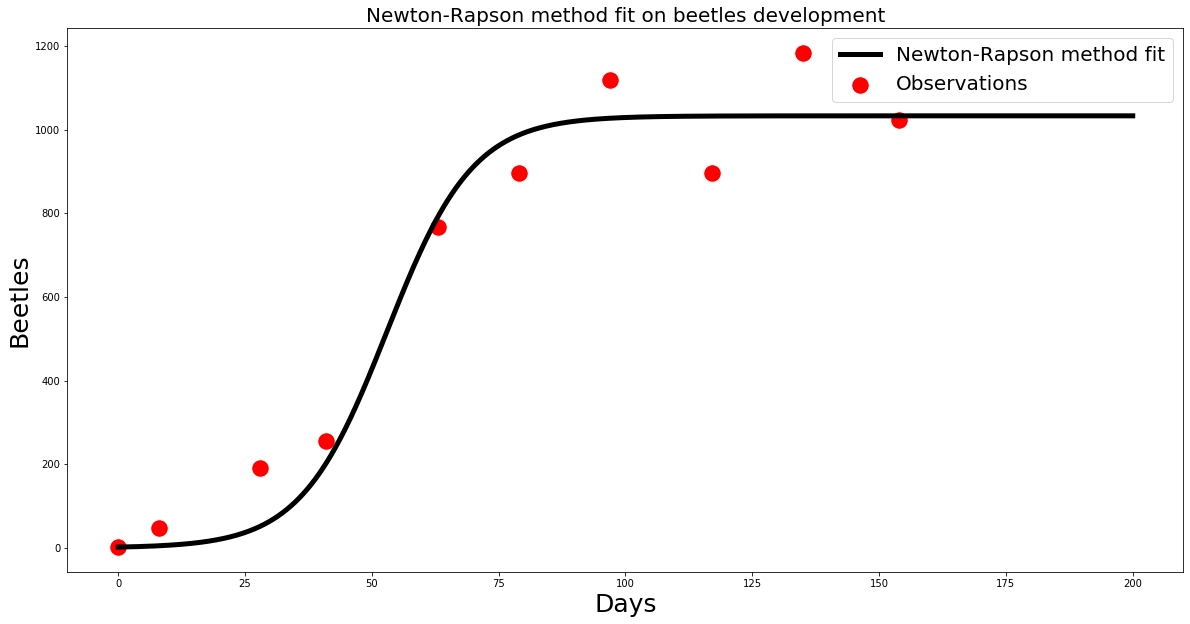

In [10]:
plt.figure(figsize = (20,10))
X_predict = Functions().Main(t_new)['F'](NR_out['K'].iloc[20], NR_out['r'].iloc[20])
sb.scatterplot(data=Dataset,x='Days',y='Beetles',color="red",alpha=1,s=300)
plt.title("Newton-Rapson method fit on beetles development",fontsize=20)
plt.plot(t_new, X_predict, 'k', linewidth= 5)
plt.legend(("Newton-Rapson method fit", "Observations"),fontsize=20)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Beetles',fontsize=25)

(c) Present your estimates in the last 5 iterations in a format similar to Table 2.1. Plot the
fitted model together with the observed data in a single plot.

### Answer to part (c):

c. In many population modeling applications, an assumption of lognormality is
adopted. The simplest assumption would be that the log Nt are independent and
normally distributed with mean log f(t) and variance σ2. Find the MLEs under
this assumption, using both the Gauss–Newton and the Newton–Raphson methods.
Provide standard errors for your parameter estimates, and an estimate of the correlation between them. Comment

if we assume that data is logaritm of the data are normally distributed with mean log f(t) and variance σ2 then we can write the new function as

\begin{equation*}
log N_t \sim N(log f(t), \sigma^2) 
\end{equation*}

\begin{equation*}
log f(t) = log \left(\frac{KN_0}{N_0 + (K-N_0)\exp{(-rt)}} \right) = log K +log N_0 - log(N_0+(K-N_0) \exp{(-rt)}) 
\end{equation*}

Then the Likelihood and logLikelihood can be written as

\begin{equation*}
L(K,r)= \prod_{i=1}m^{n} \frac{1}{\sqrt{2 \pi \sigma^2}}\exp\left(-\frac{(x_{t_{i}}-log f(t_i))^2}{2\sigma^2}\right)
\end{equation*}

\begin{equation*}
l(K,r)=log (L(k,r))=\sum_{i = 1}^{n} log\left(\frac{1}{\sqrt{2 \pi \sigma^2}}\right) - \frac{1}{2\sigma^2}\sum_{i = 1}^{n} (x_{t_{i}}-log f(t_i))^2
\end{equation*}

Therefore the seccond part of the log likelihood equation is only required to be optimised.

In [11]:
Dataset['log_Beetles'] = np.log(Dataset['Beetles'])

### the Gauss–Newton method

In [12]:
class Functions:
    """This function returns function values as well as their derivatives"""
    
    def __init__(self):
        self.func_value = 0
        self.dfunc_k_value = 0
        self.dfunc_r_value = 0

        
    def F(self, t):
        Ftot = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0, len(t)):
            Ftot[i] = log(K) + log(N0) - log(N0 + (K - N0) * sym.exp(-r * t[i]))
        return Ftot


    def dF_k(self, t):
        dFtot_k = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            dFtot_k[i] = -(exp(-r * t[i])/((K - N0) * exp(-r * t[i]) + N0)) + 1 / K
        return dFtot_k
    

    def dF_r(self, t):
        dFtot_r = zeros(len(t), 1)
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        N0 = 2
        for i in range(0,len(t)):
            dFtot_r[i] = t[i] * (K - N0) * exp(-r * t[i]) / ((K - N0) * sym.exp(-r * t[i]) + N0)
        return dFtot_r

    def Main(self, Data):
        func_eval = self.F(Data)
        self.func_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], func_eval, 'numpy')
        dfunc_k_eval = self.dF_k(Data)
        self.dfunc_k_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], dfunc_k_eval, 'numpy') 
        dfunc_r_eval = self.dF_r(Data)
        self.dfunc_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r')], dfunc_r_eval, 'numpy') 
        return {'F':self.func_value, 'dF_K':self.dfunc_k_value, 'dF_r':self.dfunc_r_value}
    
    def __repr__(self):
        return "Functions func_value:% s dfunc_k_value:% s dfunc_r_value:% s " % (self.func_value, self.dfunc_k_value, self.dfunc_r_value)  


In [13]:
GN_out_log = GN(Dataset[['log_Beetles']],900,0.5,100)

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|           0 | 636.115 | 0.401706 |     3.4566 |       209.173 |     0.0922237 |    -0.0381225 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|           1 | 671.066 | 0.400677 |    3.43246 |       147.414 |     0.0883301 |    -0.0301981 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|           2 | 672.086 | 0.400482 |    3.43244 |       155.521 |     0.0879401 |    -0.0292566 |
|   iteration |      K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+------

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          28 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          29 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          30 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          56 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          57 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          58 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          84 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          85 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+------------+---------------+---------------+---------------|
|          86 | 672.091 | 0.400461 |    3.43244 |       155.759 |     0.0879202 |    -0.0292281 |
|   iteration |       K |        r |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+-----

Text(0, 0.5, 'Log_Beetles')

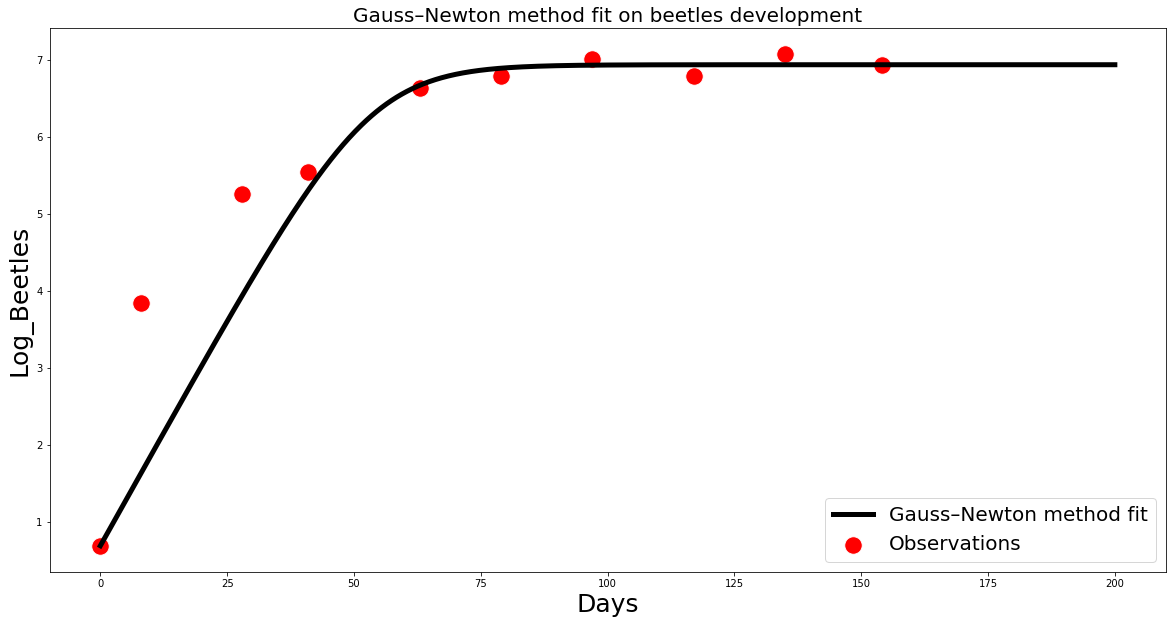

In [14]:
plt.figure(figsize = (20,10))
X_predict = Functions().Main(t_new)['F'](GN_out['K'].iloc[-1], GN_out['r'].iloc[-1])
sb.scatterplot(data=Dataset,x='Days',y='log_Beetles',color="red",alpha=1,s=300)
plt.title("Gauss–Newton method fit on beetles development",fontsize=20)
plt.plot(t_new, X_predict, 'k', linewidth= 5)
plt.legend(("Gauss–Newton method fit", "Observations"),fontsize=20)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Log_Beetles',fontsize=25)

### the Newton-Rapson method

In [15]:
class Seccond_derivatives:
    """This function returns seccond derivatives values"""
    
    def __init__(self):
        self.F =10
        self.dF_K = 0
        self.ddF_K = 0
        self.dF_r = 0
        self.ddF_r = 0
        self.ddF_K_r = 0
        self.F_value = 0
        self.dF_K_value = 0
        self.ddF_K_value = 0
        self.dF_r_value = 0
        self.ddF_r_value = 0
        self.ddF_K_r_value = 0
        self.G = 0
        self.dG_K = 0
        self.ddG_K = 0
        self.dG_r = 0
        self.ddG_r = 0
        self.ddG_K_r = 0
        
    def Func(self):
        K = sym.Symbol('K')
        r = sym.Symbol('r')
        t = sym.Symbol('t')
        N0 = 2
        self.F = sym.log(K) + sym.log(N0) - sym.log(N0 + (K - N0) * sym.exp(-r * t))
        self.dF_K = self.F.diff(K)
        self.ddF_K = self.dF_K.diff(K)
        self.dF_r = self.F.diff(r)
        self.ddF_r = self.dF_r.diff(r)
        self.ddF_K_r = self.dF_K.diff(r)
        return {'F':self.F, 'dF_K':self.dF_K, 'ddF_K':self.ddF_K, 'dF_r':self.dF_r, 'ddF_r':self.ddF_r, 'ddF_K_r':self.ddF_K_r}
    
        
    def Apply(self):
        F_eval = self.Func()['F']
        self.F_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], F_eval, 'numpy')
        dF_K_eval = self.Func()['dF_K']
        self.dF_K_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], dF_K_eval, 'numpy')
        ddF_K_eval = self.Func()['ddF_K']
        self.ddF_K_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_K_eval, 'numpy')
        dF_r_eval = self.Func()['dF_r']
        self.dF_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], dF_r_eval, 'numpy')
        ddF_r_eval = self.Func()['ddF_r']
        self.ddF_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_r_eval, 'numpy')
        ddF_K_r_eval = self.Func()['ddF_K_r']
        self.ddF_K_r_value = lambdify([sym.Symbol('K'),sym.Symbol('r'),sym.Symbol('t')], ddF_K_r_eval, 'numpy')
        return {'F_value':self.F_value, 'dF_K_value':self.dF_K_value, 'ddF_K_value':self.ddF_K_value, 'dF_r_value':self.dF_r_value, 'ddF_r_value':self.ddF_r_value, 'ddF_K_r_value':self.ddF_K_r_value}

    
    def Gfunc(self,x, t, K, r):
        i = 0
        for i in range (0,len(t)):
            self.G += (x[i] - self.Apply()['F_value'](K,r,t[i])) ** 2
            self.dG_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['dF_r_value'](K,r,t[i])
            self.dG_K += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['dF_K_value'](K,r,t[i]) 
            self.ddG_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_r_value'](K,r,t[i]) + (2 * (self.Apply()['dF_r_value'](K,r,t[i]) ** 2))
            self.ddG_K += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_K_value'](K,r,t[i]) + (2 * (self.Apply()['dF_K_value'](K,r,t[i]) ** 2))
            self.ddG_K_r += -2 * (x[i] - self.Apply()['F_value'](K,r,t[i])) * self.Apply()['ddF_K_r_value'](K,r,t[i]) + (2 * (self.Apply()['dF_K_value'](K,r,t[i]) * self.Apply()['dF_r_value'](K,r,t[i])))

        return {'G':self.G, 'dG_r':self.dG_r, 'dG_K':self.dG_K, 'ddG_r':self.ddG_r, 'ddG_K':self.ddG_K, 'ddG_K_r':self.ddG_K_r}


In [16]:
NR_out_log = NR(Dataset['log_Beetles'],200,0.5,10)

|   iteration |       K |        r | Hessian                           |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+-----------------------------------+------------+---------------+---------------+---------------|
|           0 | 313.734 | 0.324819 | [[2.87748778e-04 5.60333178e-03]  |    8.45508 |       58.9828 |     0.0989909 |    -0.0326816 |
|             |         |          |  [5.60333178e-03 1.02158286e+02]] |            |               |               |               |
|   iteration |       K |        r | Hessian                           |   residual |   std_error_r |   std_error_K |   correlation |
|-------------+---------+----------+-----------------------------------+------------+---------------+---------------+---------------|
|           1 | 448.558 | 0.404444 | [[1.11675981e-04 3.68616179e-03]  |    4.73801 |       94.6858 |      0.100116 |    -0.0349006 |
|             |         |          |  [3.68616179e-03 9.989048

Text(0, 0.5, 'Log Beetles')

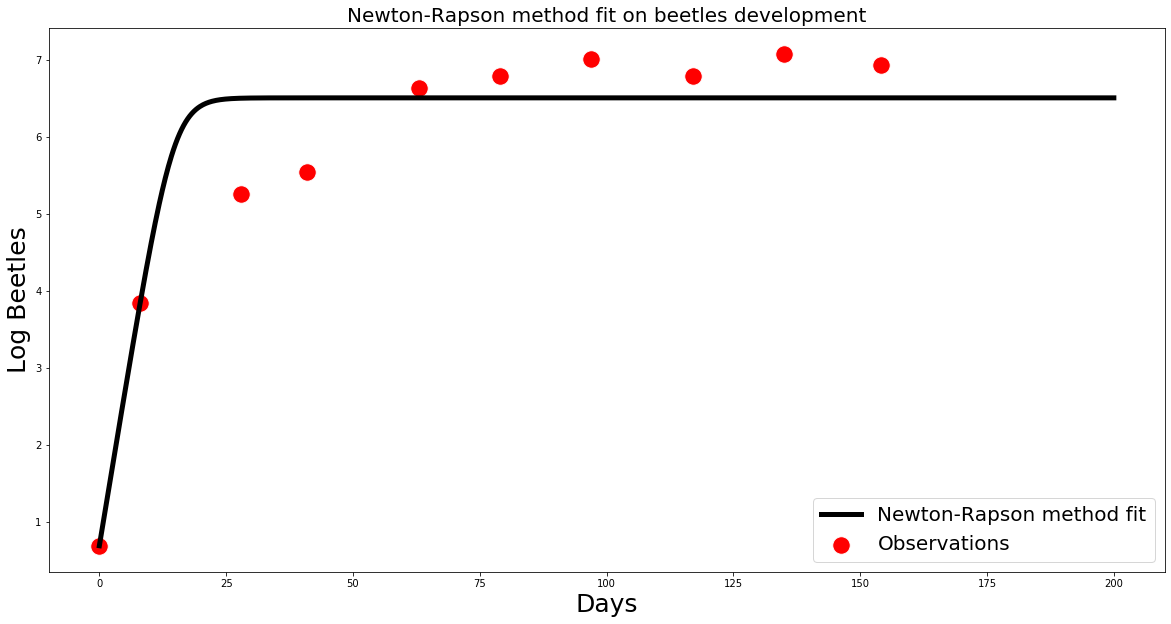

In [17]:
plt.figure(figsize = (20,10))
X_predict = Functions().Main(t_new)['F'](NR_out_log['K'].iloc[20], NR_out_log['r'].iloc[20])
sb.scatterplot(data=Dataset,x='Days',y='log_Beetles',color="red",alpha=1,s=300)
plt.title("Newton-Rapson method fit on beetles development",fontsize=20)
plt.plot(t_new, X_predict, 'k', linewidth= 5)
plt.legend(("Newton-Rapson method fit", "Observations"),fontsize=20)
plt.xlabel('Days',fontsize=25)
plt.ylabel('Log Beetles',fontsize=25)

**Both methods indicate that the correlation between the two prameters r and K is close to `zero` and therefore these two are not correlated and also both methods produce the same amount of standard error for both cases of r and K. However, if we compare the log method with the one without log data we see that using the original data results in higher amount of correlation between the two parameters but with lower standard error.**

2. Reproduce the solution to Example 4.2. That is, present the output of your code in the
format of Table 4.1.

### Answer to part (2):

The EM OPTIMIZATION METHOD

In [18]:
class ME:
    """This function is The EM algorithm iteratively seeks to maximize L(θ|x) with respect to θ. 
    Let θ(t) denote the estimated maximizer at iteration t, for t = 0, 1, . . .. 
    Define Q(θ|θ(t)) to be the expectation of the joint log likelihood for the complete data, 
    conditional on the observed data X = x."""
        
    def __init__(self, Max_iteration, eps):
        self.Max_iteration = Max_iteration
        self.eps = eps
        self.x = np.array([85, 196, 341])
        self.n = np.zeros(6)
        self.p = np.repeat((1/3), 3)
        self.pc_arrey = []
        self.pi_arrey = []
        
    
    def Expectation(self, x, p):
        cc = (x[0]*(p[0]**2))/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
        ci = (2*x[0]*p[0]*p[1])/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
        ct = (2*x[0]*p[0]*p[2])/((p[0]**2)+2*p[0]*p[1]+2*p[0]*p[2])
        ii = (x[1]*(p[1]**2))/((p[1]**2)+2*p[1]*p[2])
        it = (2*x[1]*p[1]*p[2])/((p[1]**2)+2*p[1]*p[2])
        n = np.array([cc, ci, ct, ii, it, x[2]])
        return n
    
    def Maximization(self, x, n):
        c = (2*n[0]+n[1]+n[2])/(2*sum(x))
        i = (2*n[3]+n[4]+n[1])/(2*sum(x))
        t = (2*n[5]+n[2]+n[4])/(2*sum(x))
        p = np.array([c, i, t])
        return p


    def Main(self):
        for i in range(self.Max_iteration):
            p0 = self.p
            self.pc_arrey.append(p0[0])
            self.pi_arrey.append(p0[1])
            if i == 0:
                print(tabulate([[i, p0[0], p0[1], 0, 0, 0]], 
                               headers = ['t', 'Pc(t)', 'Pi(t)', 'R(t)', 'Dc(t)', 'Di(t)'],
                               tablefmt='orgtbl'))        

            self.n = self.Expectation(self.x, self.p)
            self.p = self.Maximization(self.x, self.n)
            R = LA.norm((self.p[0:2] - p0[0:2]), 2) / LA.norm(p0[0:2], 2)
            Dc = (self.p[0] - 0.0708369) / (p0[0] - 0.0708369)
            Di = (self.p[1] - 0.188737) / (p0[1] - 0.188737)
            print(tabulate([[i+1, self.p[0], self.p[1], R, Dc, Di]], 
                           headers = ['t', 'Pc(t)', 'Pi(t)', 'R(t)', 'Dc(t)', 'Di(t)'],
                           tablefmt='orgtbl'))

            if R < self.eps:
                break;
     
    def __repr__(self):
        return "ME Max_iteration:% s eps:% s x:% s n:% s p:% s pc_arrey:% s pi_arrey:% s" % (self.Max_iteration, self.eps, self.x, self.n, self.p, self.pc_arrey, self.pi_arrey)  


In [19]:
ME(40, 0.000001).Main()

|   t |    Pc(t) |    Pi(t) |   R(t) |   Dc(t) |   Di(t) |
|-----+----------+----------+--------+---------+---------|
|   0 | 0.333333 | 0.333333 |      0 |       0 |       0 |
|   t |     Pc(t) |    Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+-----------+----------+----------+-----------+----------|
|   1 | 0.0819936 | 0.237406 | 0.570685 | 0.0425022 | 0.336587 |
|   t |    Pc(t) |   Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+----------+---------+----------+-----------+----------|
|   2 | 0.071249 | 0.19787 | 0.163121 | 0.0369333 | 0.187647 |
|   t |    Pc(t) |   Pi(t) |     R(t) |     Dc(t) |    Di(t) |
|-----+----------+---------+----------+-----------+----------|
|   3 | 0.070852 | 0.19036 | 0.035756 | 0.0367456 | 0.177756 |
|   t |     Pc(t) |    Pi(t) |       R(t) |     Dc(t) |    Di(t) |
|-----+-----------+----------+------------+-----------+----------|
|   4 | 0.0708375 | 0.189023 | 0.00658604 | 0.0372312 | 0.175997 |
|   t |     Pc(t) |    Pi(t) |       R(t) |     D